# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация
### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [32]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [33]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

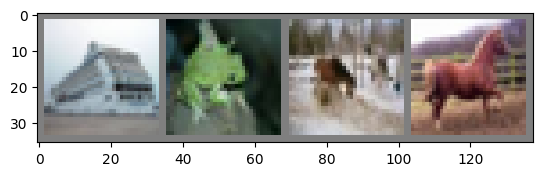

ship frog horse horse


In [34]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [35]:
n_classes = 10
n_channels = 32

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(3, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
        )

        self.shortcut = nn.Conv2d(3, n_channels, kernel_size=1)
        self.poolling = nn.AvgPool2d(kernel_size=8)

        self.linear = nn.Linear(512, n_classes)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.block(x)
        x = x + shortcut
        x = nn.ReLU()(x)
        
        x = self.poolling(x)
        x = torch.flatten(x, start_dim=1)
        return self.linear(x)

In [36]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (poolling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [37]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [39]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [40]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = nn.CrossEntropyLoss()(logits, target)
        loss_log.append(loss.item())
        
        acc = torch.sum((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.sum(acc_log) / len(loader.dataset)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = nn.CrossEntropyLoss()(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = torch.sum((logits.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 

    return np.mean(loss_log), np.sum(acc_log) / len(train_loader.dataset)

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [41]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4538125777157396, train acc: 0.4829428571428571
 val loss: 1.1964438534797506, val acc: 0.5738

Epoch 1
 train loss: 1.1428330644175164, train acc: 0.6029142857142857
 val loss: 1.1448408207994827, val acc: 0.6083333333333333

Epoch 2
 train loss: 1.0341956258038063, train acc: 0.6392857142857142
 val loss: 1.0814138757421616, val acc: 0.6283333333333333

Epoch 3
 train loss: 0.9835669849428877, train acc: 0.6578857142857143
 val loss: 1.0153662963116423, val acc: 0.6451333333333333

Epoch 4
 train loss: 0.9509138515052238, train acc: 0.6702285714285714
 val loss: 0.9984900926021819, val acc: 0.6550666666666667

Epoch 5
 train loss: 0.9280047361114125, train acc: 0.6789142857142857
 val loss: 0.953649206871682, val acc: 0.6709333333333334

Epoch 6
 train loss: 0.899377422315329, train acc: 0.6877428571428571
 val loss: 1.032915970112415, val acc: 0.6468666666666667

Epoch 7
 train loss: 0.8856789147178259, train acc: 0.6908571428571428
 val loss: 0.96717021718938

Посчитайте точность на тестовой выборке:

In [42]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9060491942296363, test acc: 0.6884


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [43]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

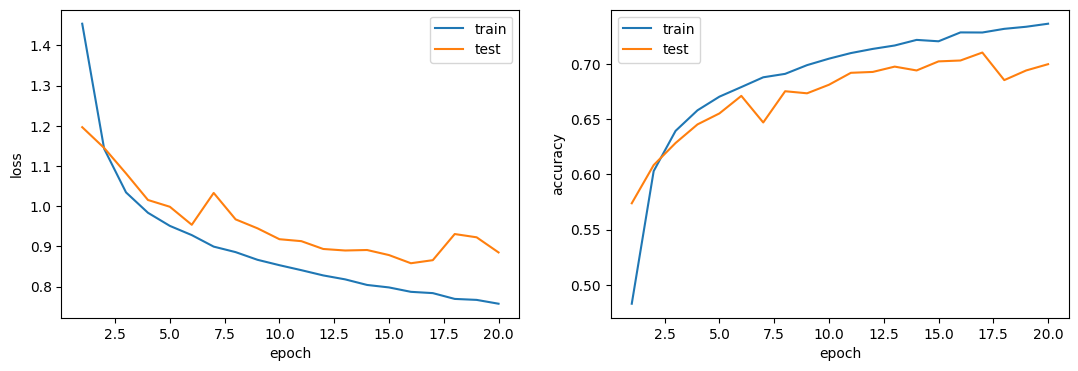

In [44]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [45]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4661198036108418, train acc: 0.4765714285714286
 val loss: 1.262489684845539, val acc: 0.5552

Epoch 1
 train loss: 1.159408891113846, train acc: 0.5934857142857143
 val loss: 1.1113606105459497, val acc: 0.6123333333333333

Epoch 2
 train loss: 1.0518248915890236, train acc: 0.6339142857142858
 val loss: 1.1479683728928263, val acc: 0.5998666666666667

Epoch 3
 train loss: 0.9881536984574424, train acc: 0.655
 val loss: 0.9791275151232456, val acc: 0.6628

Epoch 4
 train loss: 0.9455442079896247, train acc: 0.6720571428571429
 val loss: 0.9851356759984442, val acc: 0.6588666666666667

Epoch 5
 train loss: 0.9147956573440126, train acc: 0.6824571428571429
 val loss: 0.9566312972535478, val acc: 0.6710666666666667

Epoch 6
 train loss: 0.8964770698351223, train acc: 0.686
 val loss: 0.9313997063230961, val acc: 0.6802666666666667

Epoch 7
 train loss: 0.8769394318952857, train acc: 0.6946571428571429
 val loss: 0.9258101651009093, val acc: 0.6862666666666667

Epoc

Посчитайте точность на тестовой выборке:

In [46]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8294383536098869, test acc: 0.7175


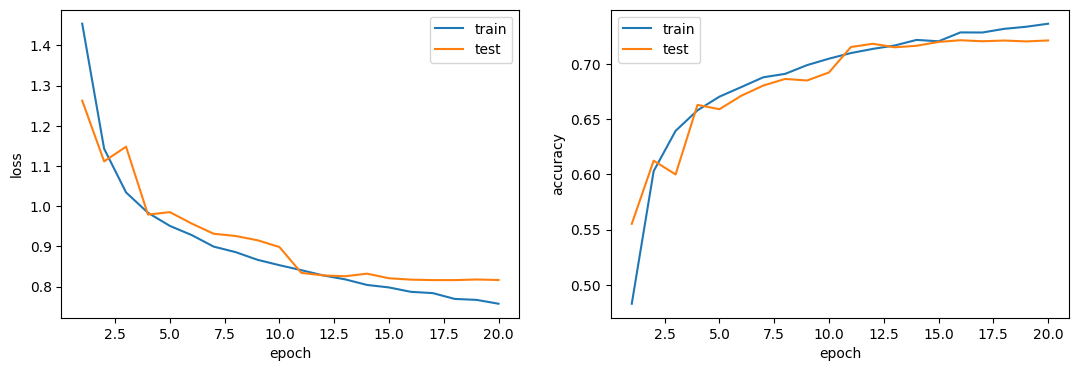

In [47]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [48]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.858756506464817, train acc: 0.3467142857142857
 val loss: 1.638502780427324, val acc: 0.43193333333333334

Epoch 1
 train loss: 1.5725990026045107, train acc: 0.44754285714285713
 val loss: 1.488421095685756, val acc: 0.4779333333333333

Epoch 2
 train loss: 1.444931786064692, train acc: 0.4922285714285714
 val loss: 1.4081134430905606, val acc: 0.5050666666666667

Epoch 3
 train loss: 1.360750271807641, train acc: 0.5225428571428572
 val loss: 1.3143241801160448, val acc: 0.5410666666666667

Epoch 4
 train loss: 1.2995969393789442, train acc: 0.5453428571428571
 val loss: 1.257596631760293, val acc: 0.5645333333333333

Epoch 5
 train loss: 1.245635228684441, train acc: 0.5637428571428571
 val loss: 1.21500615236607, val acc: 0.5781333333333334

Epoch 6
 train loss: 1.2046969115625135, train acc: 0.5814857142857143
 val loss: 1.2022831683463238, val acc: 0.5810666666666666

Epoch 7
 train loss: 1.1603013160459739, train acc: 0.5961714285714286
 val loss: 1.161343

In [49]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.9371637808289498, test acc: 0.6753


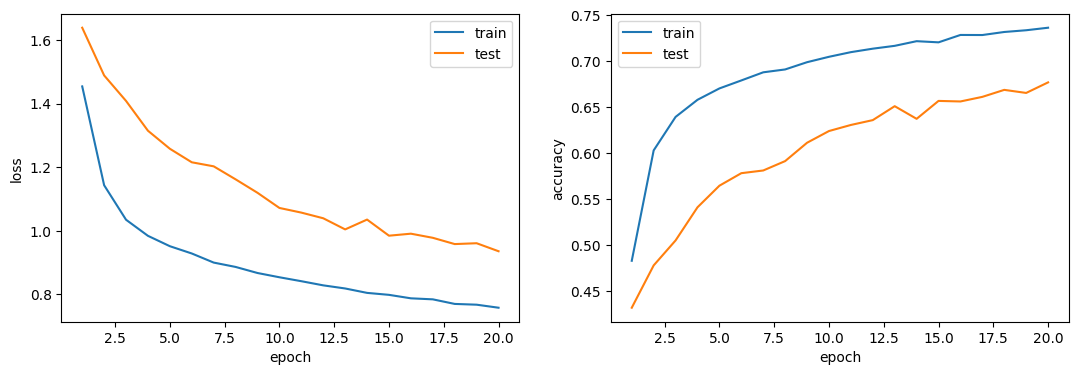

In [50]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

### StepLR: каждые step_size умножает изначальный lr на gamma. Таким образом можно сделать плавное затухание градиента

In [51]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4698376859345863, train acc: 0.47477142857142857
 val loss: 1.3078475789820894, val acc: 0.5523333333333333

Epoch 1
 train loss: 1.145552405600574, train acc: 0.6010857142857143
 val loss: 1.0503754232792144, val acc: 0.6336666666666667

Epoch 2
 train loss: 1.0371155163487742, train acc: 0.6379428571428571
 val loss: 1.0153577928847455, val acc: 0.647

Epoch 3
 train loss: 0.9749884526951875, train acc: 0.6586571428571428
 val loss: 1.0735346094090887, val acc: 0.6220666666666667

Epoch 4
 train loss: 0.9407183524677479, train acc: 0.6709142857142857
 val loss: 1.030715323509054, val acc: 0.6449333333333334

Epoch 5
 train loss: 0.8560785617427372, train acc: 0.7017142857142857
 val loss: 0.9422786091236358, val acc: 0.6753333333333333

Epoch 6
 train loss: 0.8398120844603892, train acc: 0.7085428571428571
 val loss: 0.8905939513064446, val acc: 0.6900666666666667

Epoch 7
 train loss: 0.8260521562923243, train acc: 0.714
 val loss: 0.8793064104749801, val acc:

In [52]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8379879827332345, test acc: 0.712


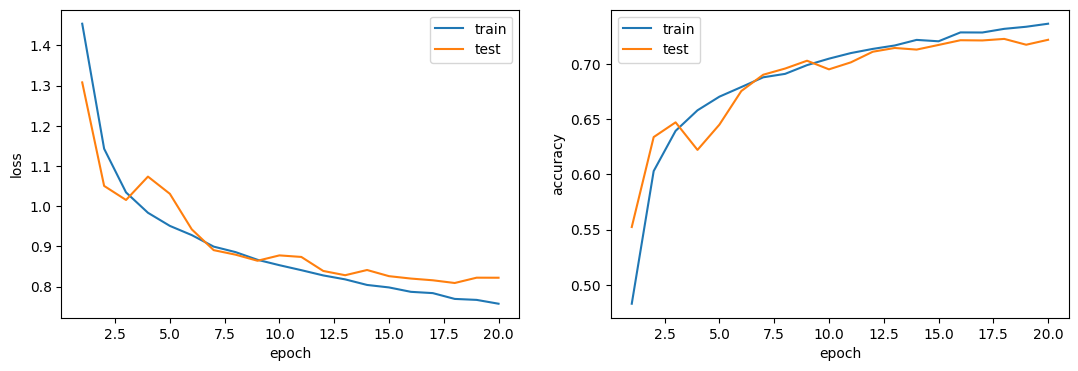

In [53]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

### OneCycleLR: сначала увеличивает изначальный lr до max_lr, после этого затухает его. Этот алгоритм был описан в статье Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates

In [54]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=len(train_loader), epochs=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.49028942157843, train acc: 0.46825714285714287
 val loss: 1.3843294179185908, val acc: 0.5118666666666667

Epoch 1
 train loss: 1.187393728732191, train acc: 0.5817428571428571
 val loss: 1.13408221513667, val acc: 0.605

Epoch 2
 train loss: 1.0601630973641571, train acc: 0.6282285714285715
 val loss: 1.0023887974150638, val acc: 0.6514666666666666

Epoch 3
 train loss: 0.994626220336126, train acc: 0.6520857142857143
 val loss: 0.9921423853711879, val acc: 0.6568666666666667

Epoch 4
 train loss: 0.9553827681532726, train acc: 0.6656
 val loss: 0.9601977419345937, val acc: 0.6635333333333333

Epoch 5
 train loss: 0.9159841974431026, train acc: 0.6828857142857143
 val loss: 0.9545741159865196, val acc: 0.6641333333333334

Epoch 6
 train loss: 0.8866341013795062, train acc: 0.691
 val loss: 0.9206049241918198, val acc: 0.678

Epoch 7
 train loss: 0.8731488280366064, train acc: 0.6959428571428572
 val loss: 0.8900245085675665, val acc: 0.6899333333333333

Epoch 8


In [55]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8395698338177553, test acc: 0.7177


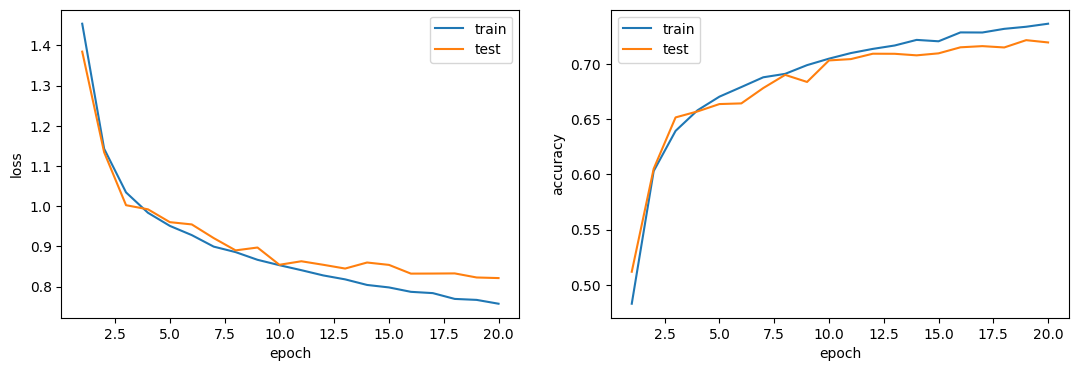

In [56]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Your answers here: 

Вывод: особо улучшить модели не получилось. Предполагаю, что более заметный эффект будет при обучении на более большом количестве эпох.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

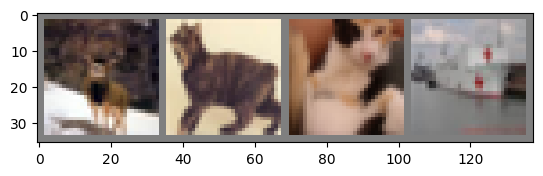

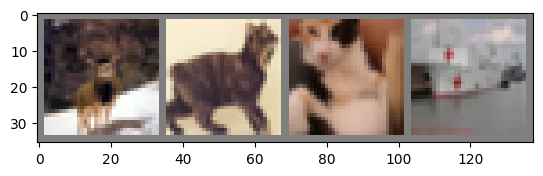

In [58]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [59]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4857281958599196, train acc: 0.46862857142857145
 val loss: 1.3571385774206608, val acc: 0.5176666666666667

Epoch 1
 train loss: 1.1903332950210224, train acc: 0.5809428571428571
 val loss: 1.0924114770077644, val acc: 0.6186

Epoch 2
 train loss: 1.064652040301119, train acc: 0.6296571428571428
 val loss: 1.0633115448850265, val acc: 0.6338666666666667

Epoch 3
 train loss: 1.0031180316395036, train acc: 0.6530571428571429
 val loss: 0.9799861289085225, val acc: 0.6618666666666667

Epoch 4
 train loss: 0.9608077254330218, train acc: 0.6673428571428571
 val loss: 0.9811762041233956, val acc: 0.6586666666666666

Epoch 5
 train loss: 0.9298845976318694, train acc: 0.6761142857142857
 val loss: 0.9575564866370343, val acc: 0.6656

Epoch 6
 train loss: 0.9058415185816763, train acc: 0.6887714285714286
 val loss: 0.9067020408650662, val acc: 0.6842

Epoch 7
 train loss: 0.8925226461516874, tr

Посчитайте точность на тестовой выборке:

In [60]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.802919006081903, test acc: 0.7216


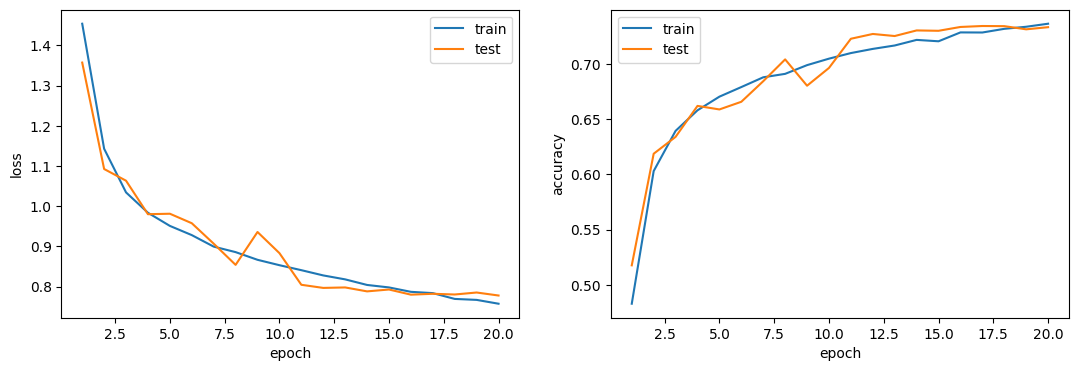

In [61]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

### ColorJitter: меняем яркость, контрастность, насыщенность изображения

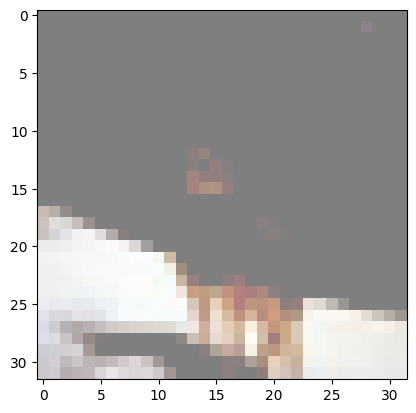

In [62]:
imshow(transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01)(images[0]))


In [63]:
transform = transforms.Compose(
        [transforms.RandomApply([
                transforms.ColorJitter(brightness=0.1),
                transforms.ColorJitter(contrast=0.01),
                transforms.ColorJitter(saturation=0.01),
         ]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4878049092929149, train acc: 0.47165714285714283
 val loss: 1.2528934169322887, val acc: 0.5500666666666667

Epoch 1
 train loss: 1.150901609626505, train acc: 0.5959428571428571
 val loss: 1.086153234319484, val acc: 0.6224666666666666

Epoch 2
 train loss: 1.0415427011371312, train acc: 0.6377142857142857
 val loss: 1.0439522410960909, val acc: 0.6412666666666667

Epoch 3
 train loss: 0.98344716456952, train acc: 0.6568857142857143
 val loss: 1.002775206718039, val acc: 0.6538

Epoch 4
 train loss: 0.9439383337658982, train acc: 0.6737428571428571
 val loss: 1.0032642935184721, val acc: 0.6483333333333333

Epoch 5
 train loss: 0.9129688325704125, train acc: 0.6838571428571428
 val loss: 1.0130885933307892, val acc: 0.6506

Epoch 6
 train loss: 0.8922815283648057, train acc: 0.6892571428571429
 val loss: 0.9476694860356919, val acc: 0.6708666666666666

Epoch 7
 train loss: 0.879418326906

In [64]:
test_loss, test_acc = test(net, test_loader)
print(f" test loss: {test_loss}, test acc: {test_acc}")

 test loss: 0.8310467767867313, test acc: 0.7192


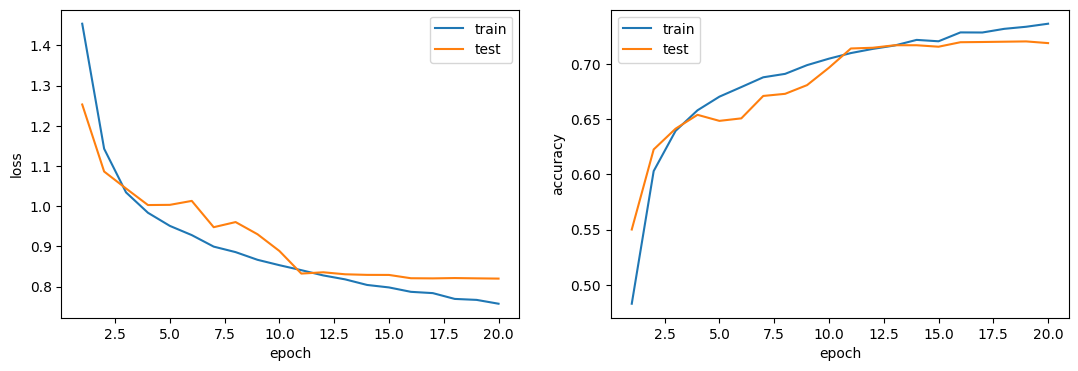

In [65]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)


Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/choosen-one/.netrc


True

In [ ]:
config = {
  "dataset": "CIFAR10",  
  "model": "BaseBlockNet",
  "learning_rate": 0.1,
  "batch_size": 64,
}

wandb.init(
    project="dl-shw-02-cnn",
    config=config
)

wandb: Currently logged in as: tararonis (my-test-organization). Use `wandb login --relogin` to force relogin


In [ ]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        metrics = {
            "train loss": train_loss, 
            "val loss": val_loss,
            "train acc": train_acc, 
            "val acc": val_acc,
        }

        wandb.log(metrics)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
wandb.finish()

Epoch 0
 train loss: 1.472894533896577, train acc: 0.4744
 val loss: 1.232055356654715, val acc: 0.5682

Epoch 1
 train loss: 1.1657467274168944, train acc: 0.5886285714285714
 val loss: 1.1203332142626985, val acc: 0.605

Epoch 2
 train loss: 1.0562618824855936, train acc: 0.6307714285714285
 val loss: 1.0187655466668148, val acc: 0.6441333333333333

Epoch 3
 train loss: 0.9951304956807515, train acc: 0.6508571428571429
 val loss: 1.0018643079920018, val acc: 0.6574

Epoch 4
 train loss: 0.9617444827090234, train acc: 0.6654285714285715
 val loss: 0.9663489884518562, val acc: 0.6692666666666667

Epoch 5
 train loss: 0.926768434657911, train acc: 0.6805142857142857
 val loss: 1.0158632088214794, val acc: 0.6592

Epoch 6
 train loss: 0.9098536863623415, train acc: 0.6834857142857143
 val loss: 0.9654358209447658, val acc: 0.6673333333333333

Epoch 7
 train loss: 0.8803247615449825, train acc: 0.6940285714285714
 val loss: 0.9414248446200756, val acc: 0.6790666666666667

Epoch 8
 train l

train acc,▁▄▅▆▆▆▇▇▇▇▇▇████████
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val acc,▁▃▅▆▆▆▆▇▇█████▇▆▇▇██
val loss,█▆▄▃▃▄▃▂▂▁▁▂▁▁▁▃▂▂▁▂
train acc,0.73923
train loss,0.74489
val acc,0.6936
val loss,0.9229


### Required charts:
https://api.wandb.ai/links/my-test-organization/p38vvayg